In [1]:
import sklearn
from scipy.ndimage import label
from sklearn.datasets import make_circles
from sympy import unpolarify
from sympy.printing.pytorch import torch



In [2]:
nsamples = 1000
x,y = make_circles(n_samples=nsamples,noise=0.03,random_state=42)


In [3]:
len(x),len(y)

(1000, 1000)

In [4]:
import pandas as pd

In [5]:
circles = pd.DataFrame({'x1':x[:,0],'x2':x[:,1],"label":y})
circles.head()

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


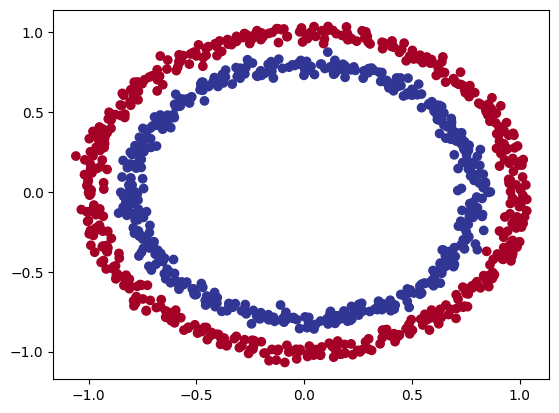

In [6]:
import matplotlib.pyplot as plt

plt.scatter(x=x[:,0],y=x[:,1],c=y,cmap=plt.cm.RdYlBu)

In [7]:
x.shape,y.shape

((1000, 2), (1000,))

In [8]:
xsample = x[0]
ysample = y[0]
xsample.shape,ysample.shape

((2,), ())

In [9]:
type(x)

numpy.ndarray

In [10]:
import torch
from torch import nn, inference_mode

In [11]:
x = torch.from_numpy(x).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

In [12]:
type(x)
x.shape,y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=42)

In [15]:
len(xtrain),len(xtest),len(ytrain),len(ytest)

(800, 200, 800, 200)

In [16]:
#accessing GPU (mps) for training
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

subclass -> `nn.module` ,almost all models in PY ssubclassess `nn.Module` <br>
create 2 `nn.Linear` layers that are capable of handling shapes of our data <br>
define a `forward()` method that outlines forward pass <br>
instantiate our model and send it o target device (mps)

In [17]:
class circlemodelv0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2,out_features=5)
        self.layer2 = nn.Linear(in_features=5,out_features=1)

    def forward(self,x):
        return self.layer2(self.layer1(x))

model_0 = circlemodelv0().to(device)
model_0


circlemodelv0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
next(model_0.parameters())

Parameter containing:
tensor([[ 0.2613,  0.4338],
        [-0.1979,  0.4186],
        [ 0.1366,  0.1057],
        [ 0.0787,  0.4954],
        [-0.5882,  0.6748]], device='mps:0', requires_grad=True)

In [19]:
model_0 = nn.Sequential(nn.Linear(in_features=2,out_features=5),nn.Linear(in_features=5,out_features=1)).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3695, -0.5948],
                      [-0.3555,  0.6544],
                      [-0.6705, -0.0981],
                      [ 0.0076,  0.1414],
                      [ 0.1467,  0.2080]], device='mps:0')),
             ('0.bias',
              tensor([-0.5782, -0.0013,  0.5527, -0.2437, -0.5971], device='mps:0')),
             ('1.weight',
              tensor([[ 0.1884, -0.4218,  0.0919, -0.4359, -0.2574]], device='mps:0')),
             ('1.bias', tensor([0.1415], device='mps:0'))])

In [21]:
xtest[:10],ytest[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

In [22]:
untrainedpred = model_0(xtest.to(device))

In [23]:
untrainedpred.shape

torch.Size([200, 1])

In [24]:
lossfn = nn.BCEWithLogitsLoss()

In [25]:
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [26]:
def accuracyfn(ytrue,ypred):
    corret = torch.eq(ytrue,ypred).sum().item()
    acc = (corret/len(ytrue))*100
    return acc

In [27]:
model_0.eval()
with torch.inference_mode():
    ylogits = model_0(xtest.to(device))[:5]
ylogits

tensor([[ 0.0024],
        [-0.1484],
        [ 0.5207],
        [-0.1449],
        [ 0.7158]], device='mps:0')

In [28]:
#using sigmoid to convert logits into prediction probability
ypredprob = torch.sigmoid(ylogits)
ypredprob

tensor([[0.5006],
        [0.4630],
        [0.6273],
        [0.4638],
        [0.6717]], device='mps:0')

In [29]:
#pred prob into tensors
ypred = torch.round(ypredprob)
ypredlables = torch.round(torch.sigmoid(model_0(xtest.to(device))[:5]))

print(torch.eq(ypred.squeeze(),ypredlables.squeeze()))

ypred.squeeze()

tensor([True, True, True, True, True], device='mps:0')


tensor([1., 0., 1., 0., 1.], device='mps:0')

In [30]:
ytest[:5]

tensor([1., 0., 1., 0., 1.])

In [31]:
torch.manual_seed(42)
torch.mps.manual_seed(42)
epochs = 100

xtrain,ytrain,xtest,ytest = xtrain.to(device),ytrain.to(device),xtest.to(device),ytest.to(device)

for epoch in range(epochs):
    #training
    model_0.train()
    #forward pass
    ylogits = model_0(xtrain).squeeze()
    ypredprob = torch.sigmoid(ylogits)
    ypred = torch.round(ypredprob)
    #loss and optimize
    loss = lossfn(ylogits,ytrain)#BCEwithloh=gitsloss needs logt=its as input,BCEwloss needs pred prob as inputs
    acc = accuracyfn(ytrain,ypred)
    optimizer.zero_grad()
    #loss backward
    loss.backward()
    optimizer.step()
    #evaluate model ,testing
    model_0.eval()
    with torch.inference_mode():
        testlogits = model_0(xtest).squeeze()
        testpredprob = torch.sigmoid(testlogits)
        testpred = torch.round(testpredprob)
        testloss = lossfn(testlogits,ytest)
        testacc = accuracyfn(ytest,testpred)
    if epoch % 10 == 0:
        print(f'epoch: {epoch}, loss: {loss}, acc: {acc} , testloss: {testloss}, testacc: {testacc}')


epoch: 0, loss: 0.7243412137031555, acc: 54.37499999999999 , testloss: 0.7056217789649963, testacc: 52.0
epoch: 10, loss: 0.7106214761734009, acc: 51.0 , testloss: 0.6965962052345276, testacc: 53.5
epoch: 20, loss: 0.705066978931427, acc: 50.24999999999999 , testloss: 0.69364333152771, testacc: 53.5
epoch: 30, loss: 0.7021723389625549, acc: 50.125 , testloss: 0.6924771070480347, testacc: 53.5
epoch: 40, loss: 0.7003263235092163, acc: 50.125 , testloss: 0.691923201084137, testacc: 54.0
epoch: 50, loss: 0.6989970207214355, acc: 49.75 , testloss: 0.6916308403015137, testacc: 54.0
epoch: 60, loss: 0.6979771256446838, acc: 49.25 , testloss: 0.6914793252944946, testacc: 52.5
epoch: 70, loss: 0.6971683502197266, acc: 49.25 , testloss: 0.6914169192314148, testacc: 53.0
epoch: 80, loss: 0.6965143084526062, acc: 49.75 , testloss: 0.691415548324585, testacc: 53.0
epoch: 90, loss: 0.6959785223007202, acc: 49.75 , testloss: 0.691457211971283, testacc: 52.5


`plot_decision_boundary`

In [32]:
import requests
from pathlib import Path

In [33]:
#downloading any required files from net
if Path("helper_functions.py").is_file():
    print("exists")
else:
    print("downloading")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions,plot_decision_boundary

exists


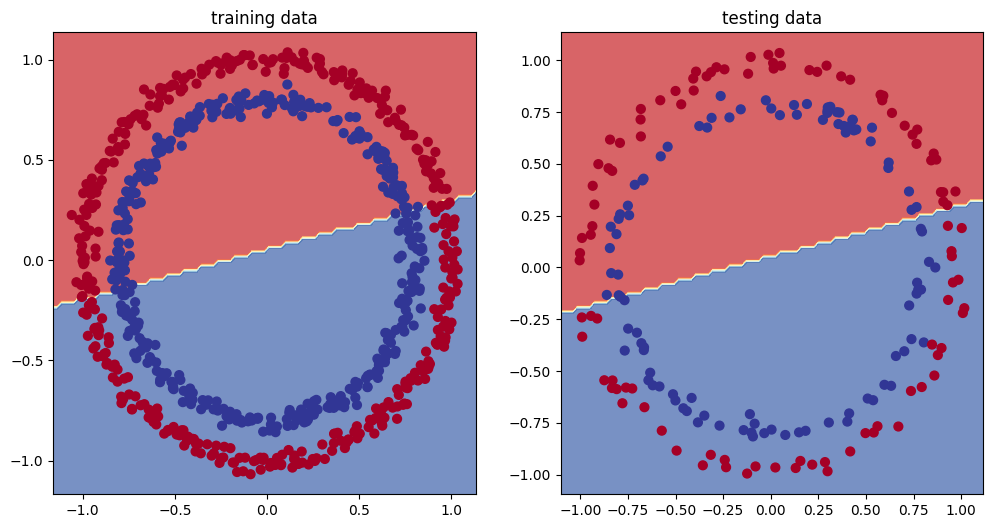

In [34]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("training data")
plot_decision_boundary(model_0,xtrain,ytrain)
plt.subplot(1,2,2)
plt.title("testing data")
plot_decision_boundary(model_0,xtest,ytest)

# improving the model
1. add more layers
2. add more hidden units
3. fit for longer
4. change activation fn
5. chnage lr rate
6. change loss fn

In [35]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3706, -0.5376],
                      [-0.3533,  0.5392],
                      [-0.6700, -0.0949],
                      [ 0.0114, -0.0027],
                      [ 0.1475,  0.1517]])),
             ('0.bias', tensor([-0.6085,  0.0602,  0.5466, -0.1742, -0.5648])),
             ('1.weight',
              tensor([[ 0.0871, -0.2067, -0.0290, -0.3752, -0.0956]])),
             ('1.bias', tensor([-0.0292]))])

In [36]:
class circlemodelv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2,out_features=10)
        self.layer2 = nn.Linear(in_features=10,out_features=10)
        self.layer3 = nn.Linear(in_features=10,out_features=1)

    def forward(self,x):
        z = self.layer1(x)
        z = self.layer2(z)
        z = self.layer3(z)
        return z

model_1 = circlemodelv1().to(device)
model_1



circlemodelv1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [37]:
model_1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='mps:0')),
             ('layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='mps:0')),
             ('layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0

In [38]:
lossfn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [39]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 1000
xtrain,ytrain,xtest,ytest = xtrain.to(device),ytrain.to(device),xtest.to(device),ytest.to(device)
for epoch in range(epochs):
    model_1.train()
    ylogits = model_1(xtrain).squeeze()
    ypredprob = torch.sigmoid(ylogits)
    ypred = torch.round(ypredprob)
    loss = lossfn(ylogits,ytrain)
    acc = accuracyfn(ytrain,ypred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_1.eval()
    with torch.inference_mode():
        testlogits = model_1(xtest).squeeze()
        testpredprob = torch.sigmoid(testlogits)
        testpred = torch.round(testpredprob)
        testloss = lossfn(testlogits,ytest)
        testacc = accuracyfn(ytest,testpred)
    if epoch % 10 == 0:
        print(f'loss: {loss}, acc: {acc}, testloss: {testloss}, testacc: {testacc:.2f}%')

loss: 0.6939550042152405, acc: 50.875, testloss: 0.6926146149635315, testacc: 51.00%
loss: 0.6936882138252258, acc: 50.24999999999999, testloss: 0.6927037239074707, testacc: 50.00%
loss: 0.6935124397277832, acc: 50.125, testloss: 0.6928301453590393, testacc: 49.50%
loss: 0.6933860778808594, acc: 50.5, testloss: 0.6929664015769958, testacc: 48.00%
loss: 0.6932917833328247, acc: 50.375, testloss: 0.6931029558181763, testacc: 49.00%
loss: 0.6932203769683838, acc: 49.875, testloss: 0.6932356357574463, testacc: 50.00%
loss: 0.6931658387184143, acc: 49.375, testloss: 0.6933621168136597, testacc: 51.50%
loss: 0.6931239366531372, acc: 49.375, testloss: 0.6934814453125, testacc: 50.50%
loss: 0.6930918097496033, acc: 50.125, testloss: 0.6935926079750061, testacc: 50.00%
loss: 0.6930670142173767, acc: 50.5, testloss: 0.693695604801178, testacc: 48.50%
loss: 0.6930477619171143, acc: 50.375, testloss: 0.6937904357910156, testacc: 48.00%
loss: 0.69303297996521, acc: 50.875, testloss: 0.6938771605491

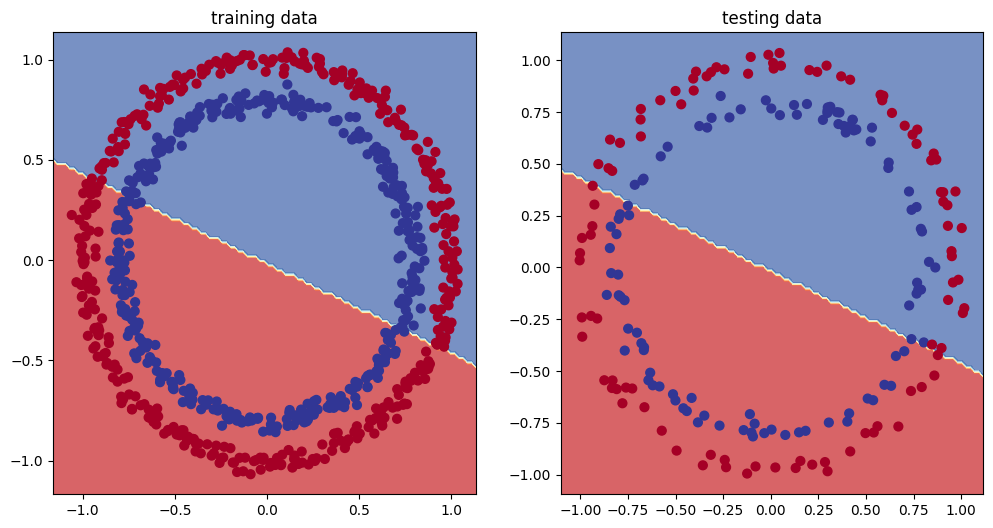

In [40]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("training data")
plot_decision_boundary(model_1,xtrain,ytrain)
plt.subplot(1,2,2)
plt.title("testing data")
plot_decision_boundary(model_1,xtest,ytest)

In [41]:
weight = 0.7
bias = 0.3

start =0
end =1
step = 0.01

xreg = torch.arange(start,end,step).unsqueeze(dim=1)
yreg = weight * xreg + bias


In [42]:
trainplit = int(0.8 *len(xreg))
xtrain,ytrain = xreg[:trainplit],yreg[:trainplit]
xtest,ytest = yreg[trainplit:],yreg[trainplit:]
len(xtrain),len(xtest),len(ytrain),len(ytest)

(80, 20, 80, 20)

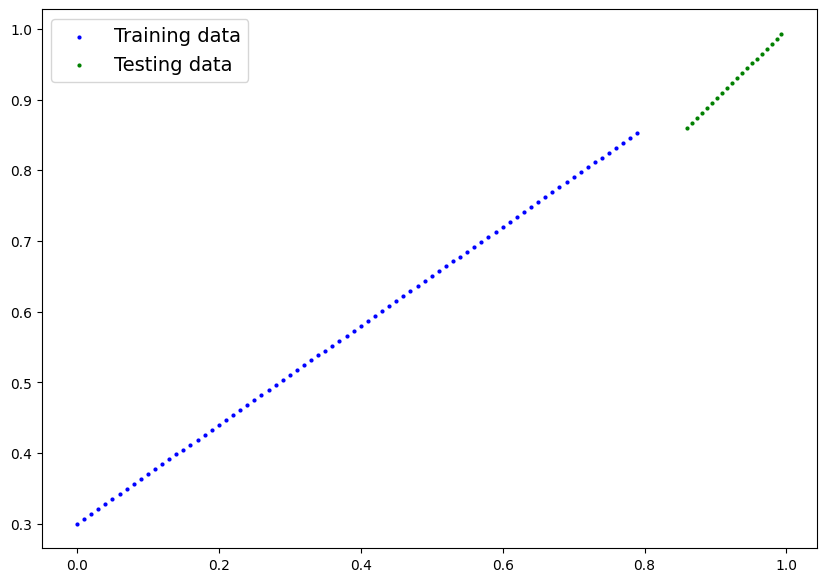

In [43]:
plot_predictions(xtrain,ytrain,xtest,ytest)

In [44]:
#adjusting model_1 to fit for straight line
model_2 = nn.Sequential(nn.Linear(in_features=1,out_features=10),
                        nn.Linear(in_features=10,out_features=10),
                        nn.Linear(in_features=10,out_features=1)).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [45]:
lossfn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [46]:
torch.manual_seed(42)
torch.mps.manual_seed(42)
epochs = 1000

xtrain,ytrain,xtest,ytest = xtrain.to(device),ytrain.to(device),xtest.to(device),ytest.to(device)

for epoch in range(epochs):
    model_2.train()
    ypred = model_2(xtrain)
    loss = lossfn(ypred,ytrain)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_2.eval()
    with torch.inference_mode():
        testpred = model_2(xtest)
        testloss = lossfn(testpred,ytest)
    if epoch %100==0:
        print(f'loss: {loss}, testloss: {testloss:.2f}%')

loss: 0.7598585486412048, testloss: 0.90%
loss: 0.028579536825418472, testloss: 0.02%
loss: 0.025325382128357887, testloss: 0.02%
loss: 0.021374715492129326, testloss: 0.02%
loss: 0.01964491419494152, testloss: 0.02%
loss: 0.019402209669351578, testloss: 0.02%
loss: 0.019032422453165054, testloss: 0.02%
loss: 0.018782898783683777, testloss: 0.02%
loss: 0.018397383391857147, testloss: 0.02%
loss: 0.017980268225073814, testloss: 0.02%


In [47]:
model_2.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.7474],
                      [ 0.8386],
                      [-0.2685],
                      [ 0.9277],
                      [-0.2253],
                      [ 0.2219],
                      [-0.5157],
                      [ 0.5984],
                      [ 0.8952],
                      [-0.7398]], device='mps:0')),
             ('0.bias',
              tensor([ 0.8181,  0.1893,  0.6798,  0.1390,  0.4719, -0.1165,  0.7276,  0.1469,
                      -0.4521,  0.2444], device='mps:0')),
             ('1.weight',
              tensor([[-6.8272e-02,  4.0207e-03, -9.4606e-02,  2.5110e-01, -2.2979e-01,
                       -1.4690e-01, -6.2611e-02, -1.6088e-01,  3.5127e-02, -3.2492e-01],
                      [ 3.0631e-01, -2.5446e-01,  2.4940e-01,  6.7609e-02, -1.0098e-01,
                        1.9585e-01,  5.0876e-02,  2.6490e-01,  4.2846e-02, -1.0855e-01],
                      [ 8.2267e-03, -1.2545e-01,  9.8334e-02,  2.426

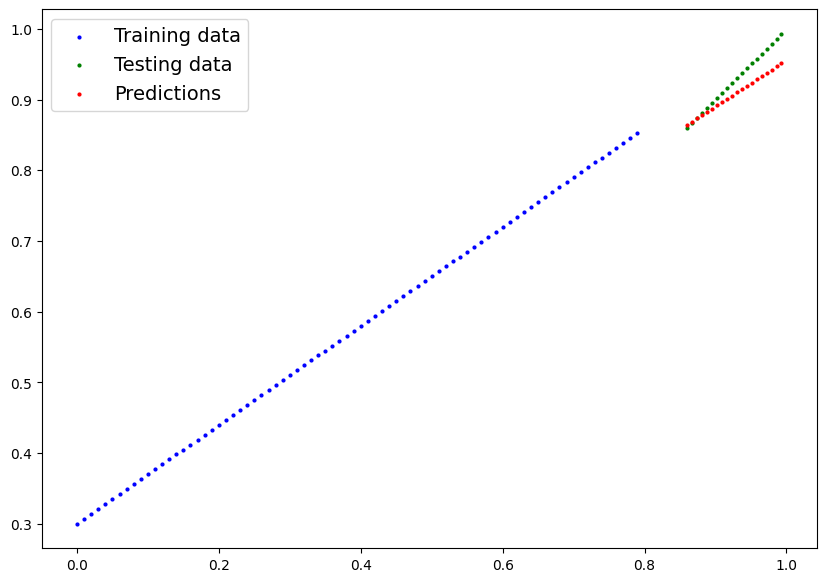

In [48]:
model_2.eval()
with torch.inference_mode():
    testpred = model_2(xtest)

plot_predictions(xtrain.cpu(),ytrain.cpu(),xtest.cpu(),ytest.cpu(),predictions=testpred.cpu())

Non-linearity

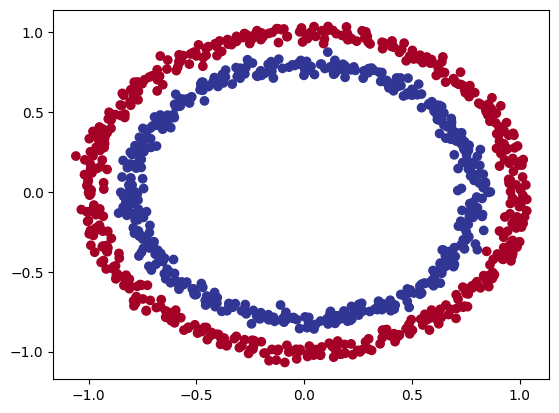

In [49]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

nsamples = 1000

x,y = make_circles(n_samples=nsamples,noise=0.03,random_state=42)
plt.scatter(x[:,0],x[:,1], c=y,cmap=plt.cm.RdYlBu)

In [50]:
import torch
from sklearn.model_selection import train_test_split

x =torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

xtrain,ytrain,xtest,ytest = train_test_split(x,y,test_size=0.2,random_state=42)

In [51]:
from torch import nn

class circlemodelv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1  = nn.Linear(in_features=2,out_features=10)
        self.layer2 = nn.Linear(in_features=10,out_features=10)
        self.layer3 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU() #relu is a activation funtion

    def forward(self,x):
       return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_3 = circlemodelv2().to(device)
model_3

circlemodelv2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [52]:
lossfn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [53]:
ytrain

tensor([[-3.7519e-01,  6.8266e-01],
        [ 1.5380e-02,  9.6003e-01],
        [-7.0278e-01, -3.1472e-01],
        [-2.8525e-01,  9.6638e-01],
        [ 4.0242e-01, -7.4375e-01],
        [ 6.3228e-01, -5.7111e-01],
        [ 8.5607e-01,  5.4994e-01],
        [ 1.0034e+00,  1.9028e-01],
        [-7.4892e-01, -2.9511e-01],
        [ 5.3780e-02,  9.7388e-01],
        [-4.7020e-01,  7.8749e-01],
        [-2.1686e-01,  7.2418e-01],
        [ 9.7026e-01,  3.6688e-01],
        [-5.8446e-01, -5.7415e-01],
        [-9.1147e-01, -2.4631e-01],
        [ 7.6892e-01, -7.3249e-02],
        [ 3.8408e-01,  6.8299e-01],
        [-6.8364e-01,  7.1417e-01],
        [-5.7777e-01,  5.3652e-01],
        [-8.3274e-01,  4.6625e-01],
        [ 1.2448e-02,  9.8709e-01],
        [ 1.0091e+00, -2.1970e-01],
        [-6.6792e-01,  4.2861e-01],
        [-8.4405e-01,  6.1718e-01],
        [ 6.3680e-01,  7.4591e-01],
        [ 8.9413e-01,  3.6390e-01],
        [-2.3460e-01, -9.6400e-01],
        [ 8.5954e-01, -5.214

In [54]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 1000
xtrain,ytrain,xtest,ytest = xtrain.to(device),ytrain.to(device),xtest.to(device),ytest.to(device)
for epoch in range(epochs):
    model_3.train()
    y_logits = model_3(xtrain).squeeze()
    ypredprob = torch.sigmoid(y_logits)
    ypred = torch.round(ypredprob)
    loss = lossfn(y_logits,ytrain)
    acc = accuracyfn(ytrain,ypred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_1.eval()
    with torch.inference_mode():
        testlogits = model_3(xtest).squeeze()
        testpredprob = torch.sigmoid(testlogits)
        testpred = torch.round(testpredprob)
        testloss = lossfn(testlogits,ytest)
        testacc = accuracyfn(ytest,testpred)
    if epoch % 10 == 0:
        print(f'loss: {loss}, acc: {acc}, testloss: {testloss}, testacc: {testacc:.2f}%')

ValueError: Target size (torch.Size([200, 2])) must be the same as input size (torch.Size([800]))

In [56]:
model_3.eval()
with torch.inference_mode():
    testlogits = model_3(xtest).squeeze()
    testpredprob = torch.sigmoid(testlogits)
    testpred = torch.round(testpredprob)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got -2)

ValueError: 'c' argument has 400 elements, which is inconsistent with 'x' and 'y' with size 800.

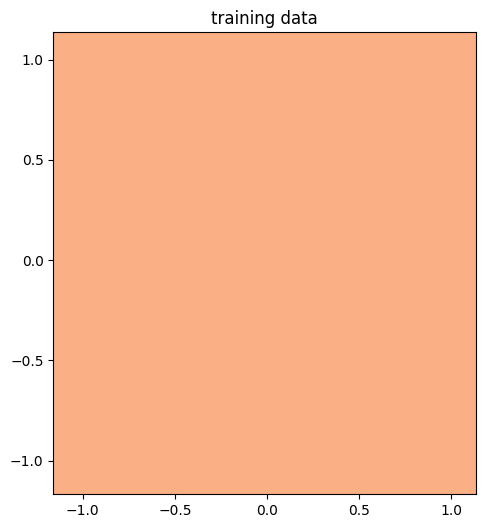

In [57]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("training data")
plot_decision_boundary(model_1,xtrain,ytrain) # linear model
plt.subplot(1,2,2)
plt.title("testing data")
plot_decision_boundary(model_3,xtest,ytest) # non linear modelS

replicting non linear activation funtions

In [58]:
A = torch.arange(-10,10,1,dtype=torch.float)
A.dtype

torch.float32

In [59]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

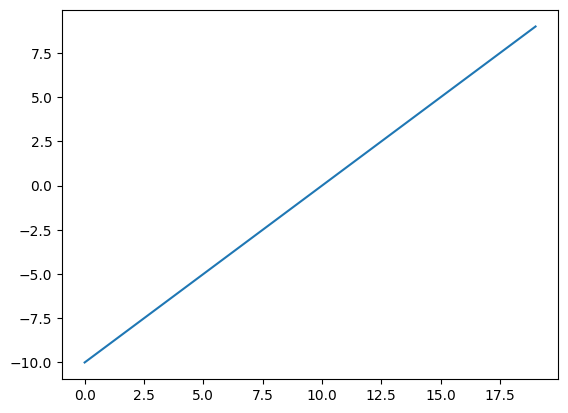

In [60]:
plt.plot(A)

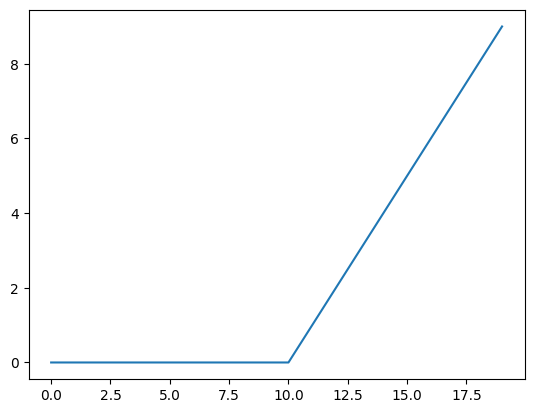

In [61]:
plt.plot(torch.relu(A))

In [62]:
def relu(x)->torch.Tensor:
    return torch.maximum(torch.tensor(0),x)

In [63]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

Multiclasss classification

In [64]:
import torch
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

numclass = 4
numfeatures = 2
randomseed = 42

xblob , yblob = make_blobs(n_samples=1000,n_features=numfeatures,random_state=randomseed,centers=numclass,cluster_std=1.5)

xblob = torch.from_numpy(xblob).type(torch.float)
yblob = torch.from_numpy(yblob).type(torch.float)

In [65]:
xblobtrain,xtestblob,yblobtrain,ytestblob = train_test_split(xblob,yblob,test_size=0.2,random_state=42)

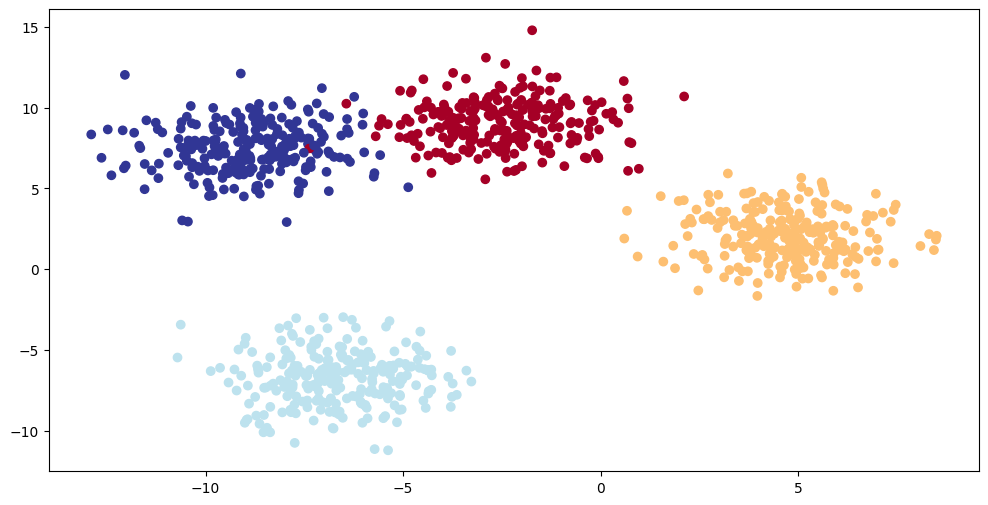

In [66]:
plt.figure(figsize=(12,6))
plt.scatter(xblob[:,0],xblob[:,1],c=yblob,cmap=plt.cm.RdYlBu)

In [67]:
#multiclass classification model
class blobModel(nn.Module):
    def __init__(self,input_features,output_features,hidden_units = 8):
        super().__init__()
        self.linearlayerstack = nn.Sequential(nn.Linear(in_features=input_features,out_features=hidden_units),
                                              nn.ReLU(),
                                              nn.Linear(in_features=hidden_units,out_features=hidden_units),
                                              nn.ReLU(),
                                              nn.Linear(in_features=hidden_units,out_features=output_features))
    def forward(self,x):
        return self.linearlayerstack(x)

model_4 = blobModel(2,4,8).to(device)
model_4

blobModel(
  (linearlayerstack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [68]:
xtrain.shape,ytrain.shape

(torch.Size([800, 2]), torch.Size([200, 2]))

In [69]:
lossfuntion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

In [70]:
model_4.eval()
with torch.inference_mode():
    ylogits = model_4(xtestblob.to(device))

In [71]:
ypredprob = torch.softmax(ylogits,dim=1)

In [72]:
ypred = torch.argmax(ypredprob,dim=1)
ypred

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='mps:0')

In [73]:
#training and testing loop for multiclass model
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 100

xblobtrain,yblobtrain,xtestblob,ytestblob = xblobtrain.to(device),yblobtrain.to(device),xtestblob.to(device),ytestblob.to(device)

for epoch in range(epochs):
    model_4.train()
    ylogits = model_4(xblobtrain)
    ypred = torch.softmax(ylogits,dim=1).argmax(dim=1)
    loss = lossfuntion(ylogits,yblobtrain)
    acc = accuracyfn(yblobtrain,ypred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_4.eval()
    with torch.inference_mode():
        testlogits = model_4(xtestblob)
        testpred = torch.softmax(testlogits,dim=1).argmax(dim=1)
        testloss = lossfuntion(testlogits,ytestblob)
    if epoch % 10 == 0:
        print(f'loss : {loss}, acc: {acc:.2f}% ')

loss : 1.1588265895843506, acc: 40.38% 
loss : 0.6447554230690002, acc: 96.75% 
loss : 0.4253515601158142, acc: 98.50% 
loss : 0.25294235348701477, acc: 99.12% 
loss : 0.11232152581214905, acc: 99.25% 
loss : 0.06626509875059128, acc: 99.25% 
loss : 0.050680141896009445, acc: 99.25% 
loss : 0.042996734380722046, acc: 99.25% 
loss : 0.03836136311292648, acc: 99.25% 
loss : 0.03524841368198395, acc: 99.25% 


In [74]:
model_4.eval()
with torch.inference_mode():
    ylogits = model_4(xtestblob)
ylogits

tensor([[ -0.6249,   5.9860,  -7.6323,  -8.4470],
        [ -2.1738,  -6.3750,  -3.7202,   3.1203],
        [ -3.4102,  -3.8958,   3.1567,  -2.6119],
        [ -1.1505,   4.1962,  -3.8472,  -4.8820],
        [  3.7548,  -1.3391,  -9.1422,  -6.9465],
        [ -2.8211,  -7.5767,  -4.2944,   3.7944],
        [ -3.0306,  -3.3328,   2.7955,  -2.1374],
        [  3.3762,  -4.0375,  -6.8987,  -3.5503],
        [ -4.3620,  -4.9904,   3.8123,  -3.3814],
        [  3.5012,  -3.0281,  -7.5401,  -4.7064],
        [  2.5349,  -4.8660,  -5.9197,  -2.1011],
        [ -1.1084,   7.2212,  -8.7214,  -9.5784],
        [  3.8244,  -2.2642,  -8.7786,  -6.1321],
        [  3.8925,  -3.9959,  -8.3434,  -4.6917],
        [  4.2013,  -3.7174,  -9.2818,  -5.5978],
        [ -1.1567,  -5.8345,  -4.0673,   2.0870],
        [ -2.3728,  -6.5535,  -3.6653,   3.2485],
        [ -2.4781,  -2.9919,   2.4828,  -1.7850],
        [ -1.5865,  -7.3585,  -5.2907,   2.7828],
        [ -2.8401,  -6.2987,  -2.3842,   2.8046],


In [77]:
ypredprod = torch.softmax(ylogits,dim=1)
ypred = torch.argmax(ypredprob,dim=1)

In [78]:
ypred[:10]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='mps:0')

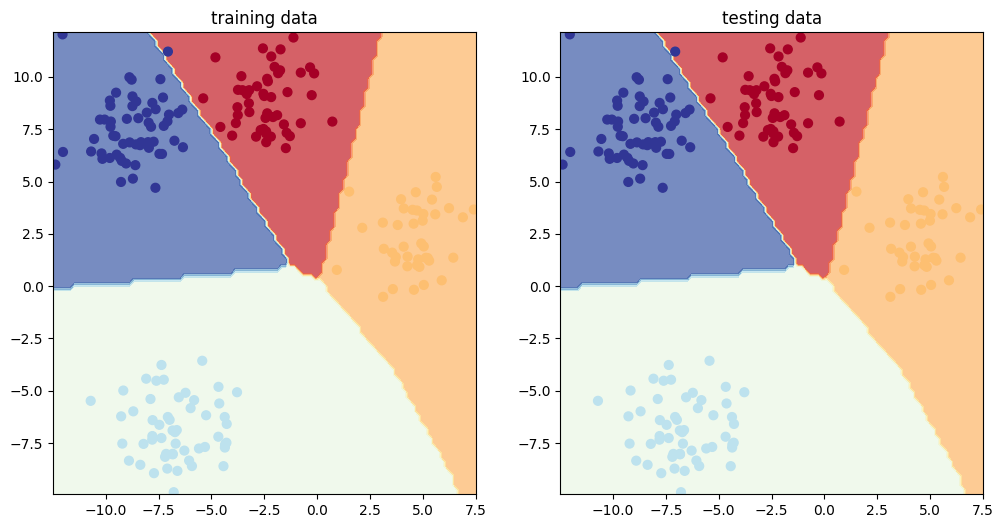

In [79]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("training data")
plot_decision_boundary(model_4,xtestblob,ytestblob)
plt.subplot(1,2,2)
plt.title("testing data")
plot_decision_boundary(model_4,xtestblob,ytestblob)

In [80]:
from torchmetrics import Accuracy


In [81]:
torchmetricacc = Accuracy(task="multiclass",num_classes=numclass).to(device)
torchmetricacc(ypred,ytestblob)

tensor(0.3550, device='mps:0')